# Multivariate Time Series, Metrics, and Validation

In [2]:
import numpy as np
import pandas as pd
import math
from math import sqrt


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', FutureWarning)

In [4]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error

## Vector AutoRegression (VAR)

In [6]:
url1 = ('https://raw.githubusercontent.com/OrangeAVA/Mastering-Time-Series-Analysis-and-Forecasting-with-Python/refs/heads/main/WeatherData.csv')

df = pd.read_csv(url1, index_col='Date', parse_dates=['Date'])

df.head()

,Unnamed: 0,Temperature (Min),Temperature (Max),Pressure,Direction of Wind,Velocity of Wind,Humidity,Carbon Monoxide,UV Rays,Intensity of Light,Clouds,Rainfall
Date,,,,,,,,,,,,
1970-01-01,0,18.0,29.0,701.0,NorthWest,0.500079,14.0,0.499990,0.973883,10001.0,Mammatus Clouds,22.0
1970-01-02,1,19.0,29.0,701.0,NorthWest,0.500081,21.0,0.499988,1.032044,10001.0,Altostratus,26.0
1970-01-03,2,18.0,29.0,701.0,SouthWest,0.500024,24.0,0.500001,1.029957,10001.0,Cumulus: Fluffy,24.0
1970-01-04,3,19.0,29.0,701.0,NorthEast,0.500064,23.0,0.500001,1.042508,10001.0,Altostratus,23.0
1970-01-05,4,19.0,29.0,701.0,NorthWest,0.500101,21.0,0.499987,1.027100,10001.0,Altostratus,25.0


In [7]:
df.drop(columns = 'Unnamed: 0', inplace = True)

df = pd.get_dummies(df, columns=['Direction of Wind', 'Clouds'], drop_first=True)

df.head()

,Temperature (Min),Temperature (Max),Pressure,Velocity of Wind,Humidity,Carbon Monoxide,UV Rays,Intensity of Light,Rainfall,Direction of Wind_NorthWest,...,Clouds_Cirrostratus,Clouds_Cirrus,Clouds_Contrails,Clouds_Cumulonimbus,Clouds_Cumulus: Fluffy,Clouds_Lenticular Clouds,Clouds_Mammatus Clouds,Clouds_Nimbostratus,Clouds_Stratocumulus,Clouds_Stratus
Date,,,,,,,,,,,,,,,,,,,,,
1970-01-01,18.0,29.0,701.0,0.500079,14.0,0.499990,0.973883,10001.0,22.0,True,...,False,False,False,False,False,False,True,False,False,False
1970-01-02,19.0,29.0,701.0,0.500081,21.0,0.499988,1.032044,10001.0,26.0,True,...,False,False,False,False,False,False,False,False,False,False
1970-01-03,18.0,29.0,701.0,0.500024,24.0,0.500001,1.029957,10001.0,24.0,False,...,False,False,False,False,True,False,False,False,False,False
1970-01-04,19.0,29.0,701.0,0.500064,23.0,0.500001,1.042508,10001.0,23.0,False,...,False,False,False,False,False,False,False,False,False,False
1970-01-05,19.0,29.0,701.0,0.500101,21.0,0.499987,1.027100,10001.0,25.0,True,...,False,False,False,False,False,False,False,False,False,False


### Check all columns for Stationarity

In [9]:
def check_stationarity(series):
    result = adfuller(series)
    if result[1] > 0.05:
        print(f"{series.name} is not stationary")
    else:
        print(f"{series.name} is stationary")

for column in df.columns:
    check_stationarity(df[column])

Temperature (Min) is not stationary
Temperature (Max) is not stationary
Pressure is not stationary
Velocity of Wind is not stationary
Humidity is stationary
Carbon Monoxide is stationary
UV Rays is not stationary
Intensity of Light is not stationary
Rainfall is stationary
Direction of Wind_NorthWest is stationary
Direction of Wind_SouthEast is stationary
Direction of Wind_SouthWest is stationary
Clouds_Altostratus is stationary
Clouds_Cirrocumulus is stationary
Clouds_Cirrostratus is stationary
Clouds_Cirrus is stationary
Clouds_Contrails is stationary
Clouds_Cumulonimbus is stationary
Clouds_Cumulus: Fluffy is stationary
Clouds_Lenticular Clouds is stationary
Clouds_Mammatus Clouds is stationary
Clouds_Nimbostratus is stationary
Clouds_Stratocumulus is stationary
Clouds_Stratus is stationary


Let us now make all data be stationary by differencing it and rechecking the values of the dataset.

In [11]:
df = df.diff().dropna()

In [12]:
for column in df.columns:
    check_stationarity(df[column])

Temperature (Min) is stationary
Temperature (Max) is stationary
Pressure is not stationary
Velocity of Wind is not stationary
Humidity is stationary
Carbon Monoxide is stationary
UV Rays is stationary
Intensity of Light is not stationary
Rainfall is stationary
Direction of Wind_NorthWest is stationary
Direction of Wind_SouthEast is stationary
Direction of Wind_SouthWest is stationary
Clouds_Altostratus is stationary
Clouds_Cirrocumulus is stationary
Clouds_Cirrostratus is stationary
Clouds_Cirrus is stationary
Clouds_Contrails is stationary
Clouds_Cumulonimbus is stationary
Clouds_Cumulus: Fluffy is stationary
Clouds_Lenticular Clouds is stationary
Clouds_Mammatus Clouds is stationary
Clouds_Nimbostratus is stationary
Clouds_Stratocumulus is stationary
Clouds_Stratus is stationary


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19650 entries, 1970-01-02 to 2023-10-20
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Temperature (Min)            19650 non-null  float64
 1   Temperature (Max)            19650 non-null  float64
 2   Pressure                     19650 non-null  float64
 3   Velocity of Wind             19650 non-null  float64
 4   Humidity                     19650 non-null  float64
 5   Carbon Monoxide              19650 non-null  float64
 6   UV Rays                      19650 non-null  float64
 7   Intensity of Light           19650 non-null  float64
 8   Rainfall                     19650 non-null  float64
 9   Direction of Wind_NorthWest  19650 non-null  object 
 10  Direction of Wind_SouthEast  19650 non-null  object 
 11  Direction of Wind_SouthWest  19650 non-null  object 
 12  Clouds_Altostratus           19650 non-null  object 
 13 

In [14]:
df = df.iloc[:, :9]  

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19650 entries, 1970-01-02 to 2023-10-20
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Temperature (Min)   19650 non-null  float64
 1   Temperature (Max)   19650 non-null  float64
 2   Pressure            19650 non-null  float64
 3   Velocity of Wind    19650 non-null  float64
 4   Humidity            19650 non-null  float64
 5   Carbon Monoxide     19650 non-null  float64
 6   UV Rays             19650 non-null  float64
 7   Intensity of Light  19650 non-null  float64
 8   Rainfall            19650 non-null  float64
dtypes: float64(9)
memory usage: 1.5 MB


In [15]:
model = VAR(df.iloc[0:989])

lag_order = model.select_order(maxlags=5)
print(lag_order.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -59.29      -59.25   1.778e-26      -59.27
1      -61.74      -61.30   1.533e-27      -61.57
2      -62.77      -61.92   5.513e-28      -62.44
3      -63.27     -62.02*   3.329e-28      -62.79
4      -63.52      -61.87   2.580e-28      -62.90
5     -63.69*      -61.63  2.187e-28*     -62.91*
-------------------------------------------------


In [16]:
model_fitted = model.fit(maxlags=5, ic='aic')

n_forecast_steps = 10 
forecast = model_fitted.forecast(df.iloc[0:989].values[-model_fitted.k_ar:], steps=n_forecast_steps)

forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=df.iloc[0:989].index[-1], periods=n_forecast_steps + 1, inclusive='right'), columns=df.columns)

In [17]:
print(forecast_df['Rainfall']) 

1972-09-17    0.854585
1972-09-18    0.076397
1972-09-19   -0.242932
1972-09-20   -0.142472
1972-09-21    0.058910
1972-09-22    0.193867
1972-09-23   -0.002728
1972-09-24   -0.093532
1972-09-25   -0.131835
1972-09-26    0.094770
Freq: D, Name: Rainfall, dtype: float64


In [18]:
df['Rainfall'].tail(10)

Date
2023-10-11   -2.0
2023-10-12   -1.0
2023-10-13    4.0
2023-10-14   -2.0
2023-10-15    2.0
2023-10-16    2.0
2023-10-17   -5.0
2023-10-18    1.0
2023-10-19   -1.0
2023-10-20    0.0
Name: Rainfall, dtype: float64

In [19]:
rmse_results = rmse(df['Rainfall'].tail(10), forecast_df['Rainfall'])
print(rmse_results)

2.544039019907296


In [20]:
forecast_df['Rainfall']

1972-09-17    0.854585
1972-09-18    0.076397
1972-09-19   -0.242932
1972-09-20   -0.142472
1972-09-21    0.058910
1972-09-22    0.193867
1972-09-23   -0.002728
1972-09-24   -0.093532
1972-09-25   -0.131835
1972-09-26    0.094770
Freq: D, Name: Rainfall, dtype: float64

In [21]:
rainfall_values = df.loc['1972-09-17':'1972-09-26', 'Rainfall']
rainfall_values

Date
1972-09-17   -1.0
1972-09-18    1.0
1972-09-19    1.0
1972-09-20    2.0
1972-09-21   -3.0
1972-09-22    0.0
1972-09-23   -1.0
1972-09-24    2.0
1972-09-25   -2.0
1972-09-26    0.0
Name: Rainfall, dtype: float64

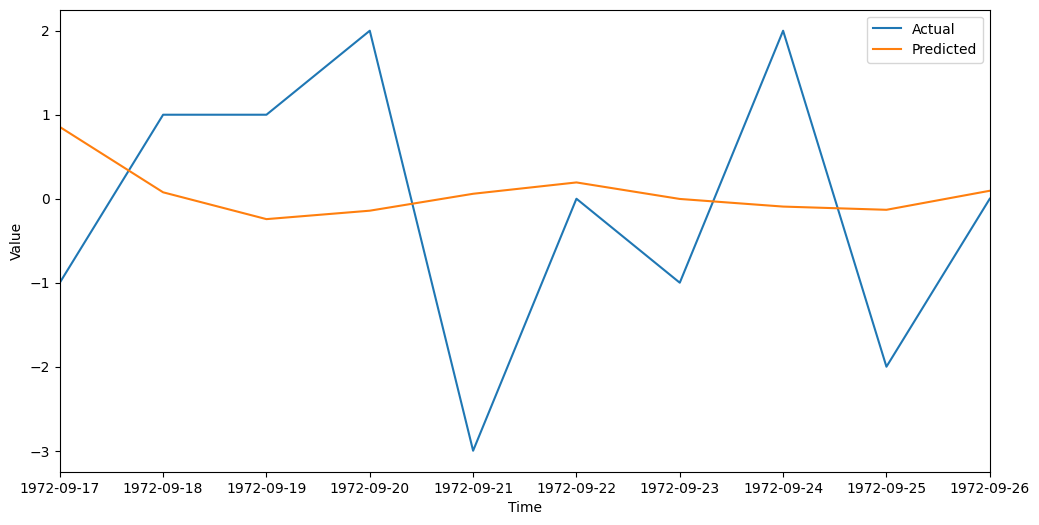

In [22]:
plt.figure(figsize=(12,6))
plt.plot(rainfall_values, label='Actual')
plt.plot(forecast_df['Rainfall'], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.xlim(pd.Timestamp('1972-09-17'), pd.Timestamp('1972-09-26'))
plt.legend()
plt.show()

*The plot signifies that the model
parameters need to be fine-tuned further to get better
predictions.*

## Vector Error Correction Model (VECM) 

The Vector Error Correction Model (VECM) is an extension of
Vector AutoRegression (VAR) model. This model is more
effective for the non-stationary data that are co-integrated. If
a variable of a time series dataset is non-stationary but still
moves along with another non-stationary variable over a
period of time, then the data is considered to be nonstationary and co-integrated. 

VECM is a model designed to
capture both short-term changes and long-term equilibrium
among co-integrated time series data. It is used when we
have multiple non-stationary time series data that are cointegrated. The most important aspect of VECM is the Error
Correction component, which handles the short-term
correlations of the data to bring them to their long-term cointegration.

In [26]:
from statsmodels.tsa.api import VECM
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tools.eval_measures import rmse

In [27]:
df = pd.read_csv(url1, index_col='Date', parse_dates=['Date'])

df.head()

,Unnamed: 0,Temperature (Min),Temperature (Max),Pressure,Direction of Wind,Velocity of Wind,Humidity,Carbon Monoxide,UV Rays,Intensity of Light,Clouds,Rainfall
Date,,,,,,,,,,,,
1970-01-01,0,18.0,29.0,701.0,NorthWest,0.500079,14.0,0.499990,0.973883,10001.0,Mammatus Clouds,22.0
1970-01-02,1,19.0,29.0,701.0,NorthWest,0.500081,21.0,0.499988,1.032044,10001.0,Altostratus,26.0
1970-01-03,2,18.0,29.0,701.0,SouthWest,0.500024,24.0,0.500001,1.029957,10001.0,Cumulus: Fluffy,24.0
1970-01-04,3,19.0,29.0,701.0,NorthEast,0.500064,23.0,0.500001,1.042508,10001.0,Altostratus,23.0
1970-01-05,4,19.0,29.0,701.0,NorthWest,0.500101,21.0,0.499987,1.027100,10001.0,Altostratus,25.0


In [28]:
df.drop(columns = 'Unnamed: 0', inplace = True)

df = pd.get_dummies(df, columns=['Direction of Wind', 'Clouds'], drop_first=True)

df.head()

,Temperature (Min),Temperature (Max),Pressure,Velocity of Wind,Humidity,Carbon Monoxide,UV Rays,Intensity of Light,Rainfall,Direction of Wind_NorthWest,...,Clouds_Cirrostratus,Clouds_Cirrus,Clouds_Contrails,Clouds_Cumulonimbus,Clouds_Cumulus: Fluffy,Clouds_Lenticular Clouds,Clouds_Mammatus Clouds,Clouds_Nimbostratus,Clouds_Stratocumulus,Clouds_Stratus
Date,,,,,,,,,,,,,,,,,,,,,
1970-01-01,18.0,29.0,701.0,0.500079,14.0,0.499990,0.973883,10001.0,22.0,True,...,False,False,False,False,False,False,True,False,False,False
1970-01-02,19.0,29.0,701.0,0.500081,21.0,0.499988,1.032044,10001.0,26.0,True,...,False,False,False,False,False,False,False,False,False,False
1970-01-03,18.0,29.0,701.0,0.500024,24.0,0.500001,1.029957,10001.0,24.0,False,...,False,False,False,False,True,False,False,False,False,False
1970-01-04,19.0,29.0,701.0,0.500064,23.0,0.500001,1.042508,10001.0,23.0,False,...,False,False,False,False,False,False,False,False,False,False
1970-01-05,19.0,29.0,701.0,0.500101,21.0,0.499987,1.027100,10001.0,25.0,True,...,False,False,False,False,False,False,False,False,False,False


In [29]:
def check_stationarity(series):
    result = adfuller(series)
    if result[1] > 0.05:
        print(f"{series.name} is not stationary")
    else:
        print(f"{series.name} is stationary")

for column in df.columns:
    check_stationarity(df[column])

Temperature (Min) is not stationary
Temperature (Max) is not stationary
Pressure is not stationary
Velocity of Wind is not stationary
Humidity is stationary
Carbon Monoxide is stationary
UV Rays is not stationary
Intensity of Light is not stationary
Rainfall is stationary
Direction of Wind_NorthWest is stationary
Direction of Wind_SouthEast is stationary
Direction of Wind_SouthWest is stationary
Clouds_Altostratus is stationary
Clouds_Cirrocumulus is stationary
Clouds_Cirrostratus is stationary
Clouds_Cirrus is stationary
Clouds_Contrails is stationary
Clouds_Cumulonimbus is stationary
Clouds_Cumulus: Fluffy is stationary
Clouds_Lenticular Clouds is stationary
Clouds_Mammatus Clouds is stationary
Clouds_Nimbostratus is stationary
Clouds_Stratocumulus is stationary
Clouds_Stratus is stationary


We will not be making the variables of this data stationary,
unlike the VAR model, since we need to check for
cointegration of this data using the Johansen cointegration
test.

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19651 entries, 1970-01-01 to 2023-10-20
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Temperature (Min)            19651 non-null  float64
 1   Temperature (Max)            19651 non-null  float64
 2   Pressure                     19651 non-null  float64
 3   Velocity of Wind             19651 non-null  float64
 4   Humidity                     19651 non-null  float64
 5   Carbon Monoxide              19651 non-null  float64
 6   UV Rays                      19651 non-null  float64
 7   Intensity of Light           19651 non-null  float64
 8   Rainfall                     19651 non-null  float64
 9   Direction of Wind_NorthWest  19651 non-null  bool   
 10  Direction of Wind_SouthEast  19651 non-null  bool   
 11  Direction of Wind_SouthWest  19651 non-null  bool   
 12  Clouds_Altostratus           19651 non-null  bool   
 13 

In [32]:
df = df.iloc[:, :9]  

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19651 entries, 1970-01-01 to 2023-10-20
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Temperature (Min)   19651 non-null  float64
 1   Temperature (Max)   19651 non-null  float64
 2   Pressure            19651 non-null  float64
 3   Velocity of Wind    19651 non-null  float64
 4   Humidity            19651 non-null  float64
 5   Carbon Monoxide     19651 non-null  float64
 6   UV Rays             19651 non-null  float64
 7   Intensity of Light  19651 non-null  float64
 8   Rainfall            19651 non-null  float64
dtypes: float64(9)
memory usage: 1.5 MB


In [33]:
def perform_johansen_test(data, det_order=0, k_ar_diff=1):
    result = coint_johansen(data, det_order, k_ar_diff)
    trace_stat = result.trace_stat
    crit_values = result.trace_stat_crit_vals
    eigenvalues = result.eig

    print("Johansen Cointegration Test Results:")
    print("------------------------------------")
    for r in range(len(trace_stat)):
        conclusion = "not rejected" if trace_stat[r] < crit_values[r, 1] else "rejected"
        print(f"Null hypothesis of rank = {r} is {conclusion}")
        print(f"Trace Statistic: {trace_stat[r]:.2f}, 95% Critical Value: {crit_values[r, 1]:.2f}")
        print(f"Eigenvalue: {eigenvalues[r]:.4f}\n")

perform_johansen_test(df) 

Johansen Cointegration Test Results:
------------------------------------
Null hypothesis of rank = 0 is rejected
Trace Statistic: 56198.36, 95% Critical Value: 197.38
Eigenvalue: 0.7527

Null hypothesis of rank = 1 is rejected
Trace Statistic: 28747.87, 95% Critical Value: 159.53
Eigenvalue: 0.3379

Null hypothesis of rank = 2 is rejected
Trace Statistic: 20645.67, 95% Critical Value: 125.62
Eigenvalue: 0.3346

Null hypothesis of rank = 3 is rejected
Trace Statistic: 12641.17, 95% Critical Value: 95.75
Eigenvalue: 0.3294

Null hypothesis of rank = 4 is rejected
Trace Statistic: 4789.64, 95% Critical Value: 69.82
Eigenvalue: 0.1364

Null hypothesis of rank = 5 is rejected
Trace Statistic: 1908.20, 95% Critical Value: 47.85
Eigenvalue: 0.0587

Null hypothesis of rank = 6 is rejected
Trace Statistic: 720.10, 95% Critical Value: 29.80
Eigenvalue: 0.0316

Null hypothesis of rank = 7 is rejected
Trace Statistic: 88.78, 95% Critical Value: 15.49
Eigenvalue: 0.0028

Null hypothesis of rank = 

This test returns the following four values that can be used to interpret the test:

**trace_stat:** The trace statistic tests the null hypothesis of r cointegrating relationships against the alternative of n cointegrating relationships.

**trace_stat_crit_vals:** The trace statistic critical values are
the critical values for the trace statistic at common
significance levels of 90%, 95%, and 99%.

**eig:** The eig is the eigenvalues for the test.

**cvt:** The cvt is the Critical Value Table for the test.

The null hypothesis is rejected for each rank tested from 0 to
23. This is indicated by the trace statistics being higher than
the corresponding critical values. Critical values are present
from rank 12 onwards. 

The test results suggest that there
are multiple cointegrating relationships within the dataset,
up to the highest rank tested. The eigenvalues for each rank are generally decreasing, but all are significant, even for
higher ranks, indicating strong evidence of cointegration
across multiple variables. 

The results indicate that we have
so many cointegrating relationships. This could imply that
the variables in the dataset are highly interconnected. This is
expected in this dataset since it is Weather data, and the
factors are related to each other in many ways. The results
strongly suggest the presence of cointegration among the
variables in this dataset, indicating that a Vector Error
Correction Model (VECM) might be appropriate for modeling
and forecasting these time series.

In the next step, let us initialize a VECM model with the first
990 records of the dataset.

In [36]:
vecm = VECM(df.iloc[0:990], k_ar_diff=1, coint_rank=1)  
vecm

In [37]:
vecm_fitted = vecm.fit()
vecm_fitted

In [38]:
n_forecast_steps = 10  

forecast, lower, upper = vecm_fitted.predict(n_forecast_steps, alpha=0.05)

forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=df.iloc[0:990].index[-1], 
                           periods=n_forecast_steps + 1, inclusive='right'), 
                           columns=df.iloc[0:990].columns)

In [39]:
print(forecast_df['Rainfall'])  

1972-09-17    23.469171
1972-09-18    23.298861
1972-09-19    23.256487
1972-09-20    23.233511
1972-09-21    23.250331
1972-09-22    23.250522
1972-09-23    23.247852
1972-09-24    23.249344
1972-09-25    23.248316
1972-09-26    23.249100
Freq: D, Name: Rainfall, dtype: float64


In [40]:
rainfall_values = df.loc['1972-09-17':'1972-09-26', 'Rainfall']
rainfall_values

Date
1972-09-17    21.0
1972-09-18    22.0
1972-09-19    23.0
1972-09-20    25.0
1972-09-21    22.0
1972-09-22    22.0
1972-09-23    21.0
1972-09-24    23.0
1972-09-25    21.0
1972-09-26    21.0
Name: Rainfall, dtype: float64

In [41]:
rmse_results = rmse(df['Rainfall'].tail(10), forecast_df['Rainfall'])
print(rmse_results)

1.799871266419309


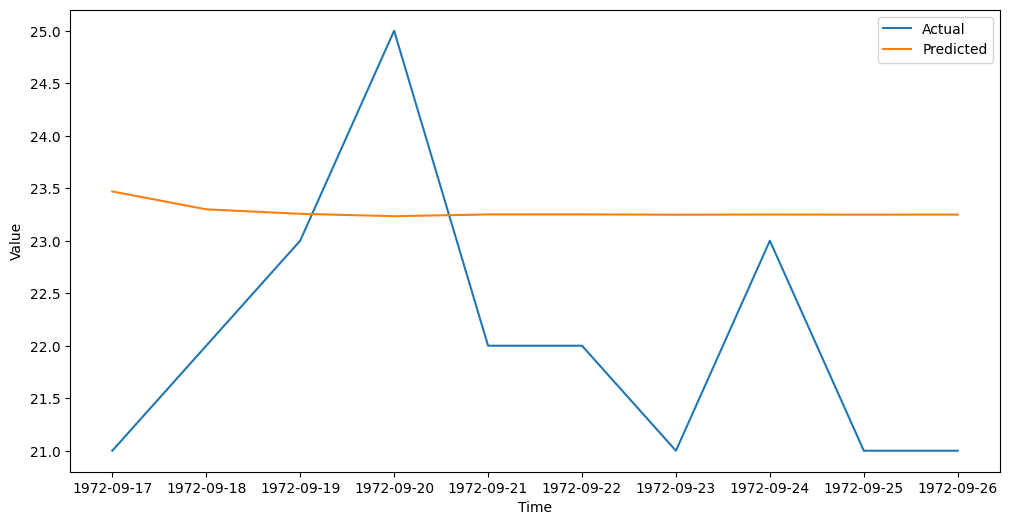

In [42]:
plt.figure(figsize=(12,6))
plt.plot(rainfall_values, label='Actual')
plt.plot(forecast_df['Rainfall'], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

*The plot in signifies that the model parameters
might need slight fine-tuning, but it is much better than the
VAR model and closer to the actual values, even though the
randomness is not well captured.*

### VARMAX

VARMAX (Vector AutoRegressive Moving Average with
eXogenous inputs) is an extension of the VAR (Vector
AutoRegression) and VMA (Vector Moving Average) models.
Similar to VAR and VECM, this model also handles
multivariate time series data. As the name implies, the three
components of VARMAX are VAR, VMA, and exogenous
inputs. 

Exogenous inputs are external factors that can impact the time series data without being a feature within
the dataset.

In [46]:
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

In [47]:
df = pd.read_csv(url1, index_col='Date', parse_dates=['Date'])

In [48]:
endog = df.loc['2010-01-01':'2023-10-20', ['Pressure', 'Velocity of Wind', 'Carbon Monoxide', 'Rainfall']]

In [49]:
# Assign 'Rainfall' as exogenous variable
exog = endog['Rainfall']  

# Define VARMAX model with specified endogenous variables and lags
mod = VARMAX(endog[['Pressure', 'Velocity of Wind', 'Carbon Monoxide']], order=(2,0), trend='n', exog=exog)

In [50]:
# Fit the VARMAX model with a maximum of 10 iterations and no display of progress
res = mod.fit(maxiter=10, disp=False)

In [51]:
# Display the summary of the fitted VARMAX model
res.summary()

Dep. Variable:,"['Pressure', 'Velocity of Wind', 'Carbon Monoxide']",No. Observations:,5041
Model:,VARX(2),Log Likelihood,-105088.218
Date:,"Tue, 04 Mar 2025",AIC,210230.436
Time:,09:20:52,BIC,210406.620
Sample:,01-01-2010,HQIC,210292.160
,- 10-20-2023,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"458.63, 5025.50, 5021.77",Jarque-Bera (JB):,"33.41, 912.21, 914.28"
Prob(Q):,"0.00, 0.00, 0.00",Prob(JB):,"0.00, 0.00, 0.00"
Heteroskedasticity (H):,"1.83, 1.78, 4.48",Skew:,"-0.14, 1.04, 1.04"
Prob(H) (two-sided):,"0.00, 0.00, 0.00",Kurtosis:,"3.28, 3.01, 3.00"


In [52]:
# Generate predictions using the fitted VARMAX model
predictions = res.predict(start=endog.index[0],  # Start prediction from the first date in the index of 'endog'
                          end=endog.index[-1],   # End prediction at the last date in the index of 'endog'
                          exog=exog)             # Include 'exog' as the external variable for predictions

In [53]:
# Show the predictions generated for 'Pressure', 'Velocity of Wind', and 'Carbon Monoxide'.
predictions, endog[['Pressure', 'Velocity of Wind', 'Carbon Monoxide']]  

(               Pressure  Velocity of Wind  Carbon Monoxide
 2010-01-01   736.576538         19.931208         0.395555
 2010-01-02   713.323268         11.967011         0.540422
 2010-01-03   733.835278          8.465237         0.638183
 2010-01-04   733.838946          8.466458         0.638161
 2010-01-05   733.842885          8.467757         0.638137
 ...                 ...               ...              ...
 2023-10-16  1034.145018         54.356050        -0.009547
 2023-10-17   860.807439         50.018164        -0.109798
 2023-10-18   895.580929         50.920806        -0.090381
 2023-10-19   860.996313         50.080627        -0.110926
 2023-10-20   861.090793         50.111866        -0.111489
 
 [5041 rows x 3 columns],
             Pressure  Velocity of Wind  Carbon Monoxide
 Date                                                   
 2010-01-01     712.0          3.068757         0.499999
 2010-01-02     712.0          3.070291         0.500001
 2010-01-03     712.0   

In [54]:
# Initialize an empty dictionary to store RMSE values for each variable
rmse_values = {}

# Loop through each column and compute RMSE by comparing the actual and predicted values
for column in ['Pressure', 'Velocity of Wind', 'Carbon Monoxide']:
    rmse = sqrt(mean_squared_error(endog[column], predictions[column]))  # Calculate RMSE for the column
    rmse_values[column] = rmse                                           # Store the RMSE value in the dictionary

# Print RMSE values for each variable
print("RMSE values:")
print('---------------')

# Display the RMSE values for each variable in the rmse_values dictionary
for var, value in rmse_values.items():
    print(f"{var}: {value}")

RMSE values:
---------------
Pressure: 65.82456294685251
Velocity of Wind: 5.479666081337899
Carbon Monoxide: 0.20586129645420356
